# Predicting Weak Lensing Shear

##### Spencer Everett, SLAC 2015

This notebook is the second of two demos that showcase the work done on `Pangloss` during the Summer of 2015. Here we describe how to predict the shear of generated sources using a catalog of foreground galaxies rather than ray-traced shear and convergence maps.

First import the necessary code modules,

In [1]:
import numpy as np
import scipy as sp
import os, sys, cmath

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pangloss

and load in the (0,0,0,0) convergence and shear maps for plotting/comparrison purposes.

In [3]:
K = pangloss.Kappamap(pangloss.demo_data_files['kappa_file'], FITS=False)
S = pangloss.Shearmap([pangloss.demo_data_files['gamma_1_file'], pangloss.demo_data_files['gamma_2_file']], FITS=False)

## Foreground Galaxy Catalog

The ray-traced convergence and shear maps from the Millennium Simulation also come with catalogs of the foreground galaxies and their corresponding dark matter halos used to determine the ray-traced maps. In each 4x4 deg^2 map, there are 16 1x1 deg^2 foreground catalogs, each with nearly 300,000 galaxies.

To construct a `ForegroundCatalog` object with Millennium Simulation data, a configuration file is needed to set various parameters. An example of a `config` file used for this work is given in the `examples` directory in `Pangloss`. The filenames for the foreground catalogs are similar to the ray-traced maps, but have the additional indicies `i` and `j` as each catalog only spans a 1 x 1 deg^2 field (1/16th of a shear or convergence map).

In [4]:
config = pangloss.Configuration(pangloss.demo_data_files['config_file'])
F = pangloss.ForegroundCatalog(pangloss.demo_data_files['guo_file'], config)

['/Users/pjm/work/stronglensing/H0/lightcones/Pangloss/calib/Millennium/catalog_example.txt']
['/Users/pjm/work/stronglensing/H0/lightcones/Pangloss/calib/Millennium/GGL_los*.fits']


Here we loaded the (0,0) catalog in the (0,0) map. A `ForegroundCatalog` contains all of foreground galaxies in the given `(x,y,i,j)` catalog, but galaxies of interest can be extracted using the `return_galaxies()` method:

In [5]:
massive_galaxies = F.return_galaxies(mass_lim=[10**10, 10**12])

The method can be used with any combination of magnitude (`mag_lim`), mass (`mass_lim`), redshift (`z_lim`), or world coordinates (`ra_lim` and `dec_lim`) limits. By default, these cutoffs are set to

`mag_lim = [0,24]`

`mass_lim = [0,10**20]`

`z_lim = [0,1.3857]`

`ra_lim = dec_lim = None`

The `ForegroundCatalog` can be plotted with the `plot()` method, but is only very useful when plotted with limitations as there are ~270,000 foreground galaxies per catalog. Foreground galaxies are plotted as orange circles. The convergence and shear maps are overlayed for reference.

/Users/pjm/work/stronglensing/LSST/DESC/Pangloss/pangloss/shearmap.py:116: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gamma1 = self.values[0][pix_yi:pix_yf,pix_xi:pix_xf]
/Users/pjm/work/stronglensing/LSST/DESC/Pangloss/pangloss/shearmap.py:117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gamma2 = self.values[1][pix_yi:pix_yf,pix_xi:pix_xf]
/Users/pjm/work/stronglensing/LSST/DESC/Pangloss/pangloss/shearmap.py:140: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ax.quiver(X[::N,::N],Y[::N,::N],dx[::N,::N],dy[::N,::N],color='r',headwidth=0,pivot='middle',transform=ax.get_transform('world'))


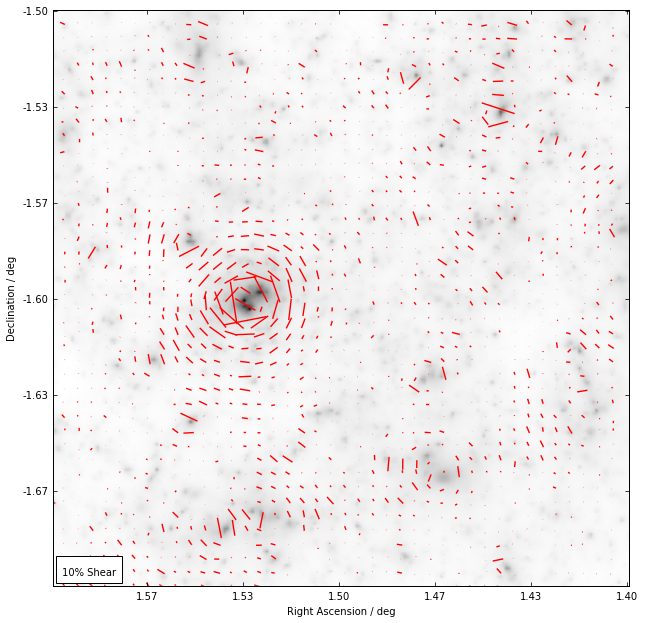

In [6]:
K.plot(fig_size=10, subplot=[1.6, 1.4, -1.7, -1.5])
S.plot()
F.plot(mass_lim=[10**10.7, 10**12])

Note that the most massive galaxies are located at convergence peaks as expected. However, there is a slight misalignment between the peaks and the center of the orange circles; the foreground galaxy locations are weakly lensed themselves! This small deviation is currently not accounted for in our framework.

## Lensing by Halos

In real surveys, we do not have convergence/shear maps to determine galaxy lensing. `Pangloss` tries to predict the lensing given a catalog of foreground objects with their properties like stellar mass and spectroscopic reddshift. However for a first attempt at prediction, here we assume complete knowledge of the dark matter halo masses of each galaxy and its true redshift. For a complete description of assumptions and methodology, see [this paper](https://github.com/drphilmarshall/Pangloss/blob/wl/doc/FinalPaper_SEverett.pdf).

First we generate a catalog of background sources in the same way as the `MockCatalogs` demo, but over a smaller region using the kwarg `domain`:

In [7]:
B = pangloss.BackgroundCatalog(N=30, domain=[1.65, 1.35, -1.65, -1.35], field=[0, 0, 0, 0], sigma_e=0.05)

Before the lensing prediction can be made, each source has a 'lightcone' drilled around it and populated with all foreground galaxies contained in that volume. This is done by calling the `drill_lightcones()` method on a `BackgroundCatalog`

In [ ]:
B.drill_lightcones(radius=2, foreground=F)

which has the optional kwargs for the radius of the lightcone `radius` and foreground catalog `foreground`. As long as the background catalog was generated correctly, it will automatically load the correct foreground catalog. However, if the catalog has already been loaded (such as in this notebook) it is quicker to pass the catalog.

After drilling, the sources are ready to be lensed. Simply call the `lens_by_halos()` method:

In [9]:
B.lens_by_halos()

AttributeError: 'int' object has no attribute 'ID'

The `Pangloss`-predicted ellipticities are added to `B.galaxies` with keywords `e1_halo` and `e2_halo`. The lensed ellipticities can be plotted in the same way as the intrinsic ellipticities; simply pass the kwarg `lensed='halo'`. `Pangloss` ellipticities are always plotted in purple.

UnboundLocalError: local variable 'world' referenced before assignment

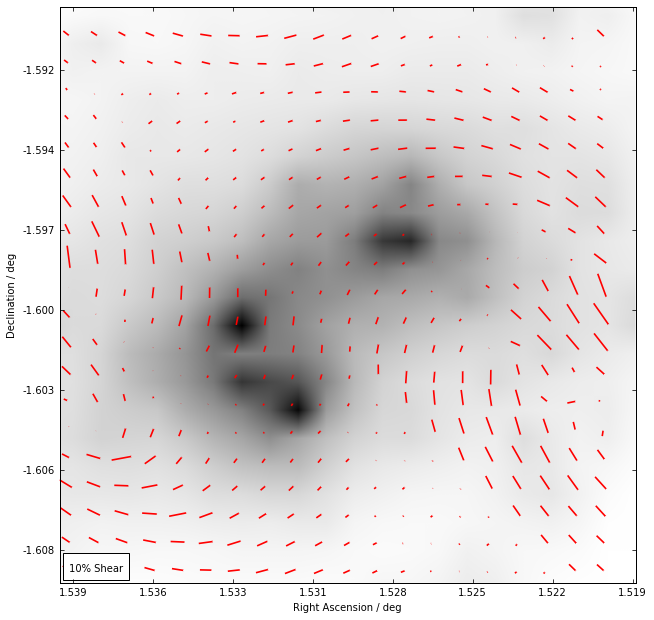

In [10]:
K.plot(fig_size=10,subplot=[1.54, 1.52, -1.61, -1.59])
S.plot()
B.plot(mass_lim=[10**11, 10**12], graph='stick')
B.plot(mass_lim=[10**11, 10**12], graph='stick', lensed='halo') 

## Comparing Lensing by Maps vs by Halos

To compare the predicted lensing to the "true" lensing by the convergence and shear maps, we must first calculate the lensing by maps:

In [11]:
B.lens_by_map(K, S)

/Users/pjm/work/stronglensing/LSST/DESC/Pangloss/pangloss/background.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.galaxies['strong_flag'][np.abs(g)>0.5] = 1


There are now 3 different types of ellipticities being saved to the background catalog. As a reminder, they are of the form:
    
`e1_int` and `e2_int`: Intrinsic ellipticities before lensing.
    
`e1_halo` and `e2_halo`: `Pangloss`-predicted lensing using halo model.

`e1` and `e2`: Actual lensing calculated by shear and convergence maps.

A simple way to compare the two lensings is to plot both by setting the `lensing` kwarg to `'both'`:

KeyError: 'eMod_halo'

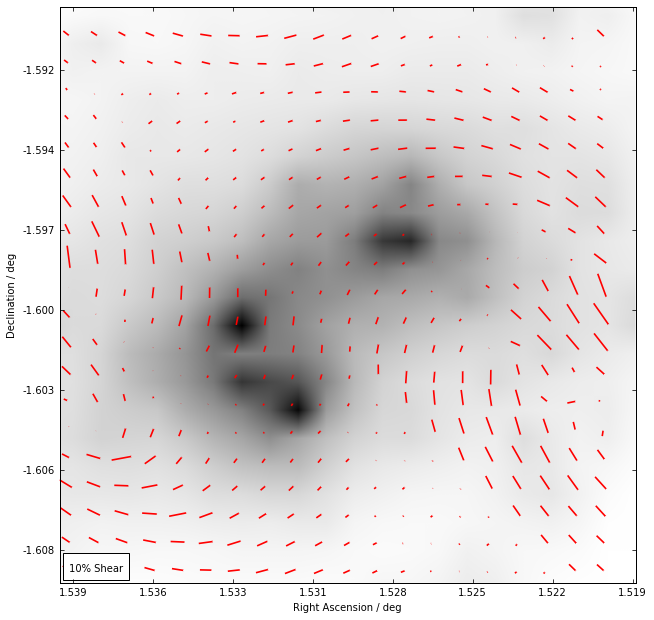

In [12]:
K.plot(fig_size=10, subplot=[1.54, 1.52, -1.61, -1.59])
S.plot()
B.plot(mass_lim=[10**11, 10**12], graph='stick', lensed='both')

For a more quantitative comparrison, we can use Mike Jarvis's `TreeCorr` (see [this page](https://github.com/rmjarvis/TreeCorr) for details) to calculate the ellipticity-ellipticity and galaxy-mass correlation functions. To do so, use the `calculate_corr()` method on the background catalog. The method has the following important kwargs:

`corr_type`: The type of correlation function calculated. The default is ellipticity-ellipticity (`gg`), but the method also supports the galaxy-mass correlation function (`ng`).

`min_sep` and `max_sep`: The minimum and maximum separation distances used when calculating the correlation function. These are set to 0.1 and 2 arcminutes by default.

`sep_units`: The units of the `min_sep` and `max_sep` inputs. The default is arcminutes.

`N`: The number of bins, set to 15 by default.

`lensed`: Determines which ellipticities are to be used for the correlation function. As with plotting, use `none` for the intrinsic ellipticities, `map` for the ray-traced ellipticities, and `halo` for the `Pangloss`-predicted ellipticities.

`foreground`: Set to `None` by default, a foreground catalog can be passed to speed up the galaxy-mass correlation function. If needed but not passed, the correct catalog will be loaded automatically.

Due to all of these options, the correlation values are stored in a separate object rather than in the catalog itself. First let's calculate the ellipticity-ellipticity correlation function:

In [13]:
gg_none = B.calculate_corr(corr_type='gg', lensed='none')
gg_map = B.calculate_corr(corr_type='gg', lensed='map')
gg_halo = B.calculate_corr(corr_type='gg', lensed='halo')

KeyError: 'e1_halo'

For greatest flexibility, each correlation function is plotted individually using the `plot_corr()` function to allow choice of color, linestyle, etc. Any additional plot is overlayed over the previous plot(s). To plot the $\xi_+$ component for all three at once, do the following:

NameError: name 'gg_halo' is not defined

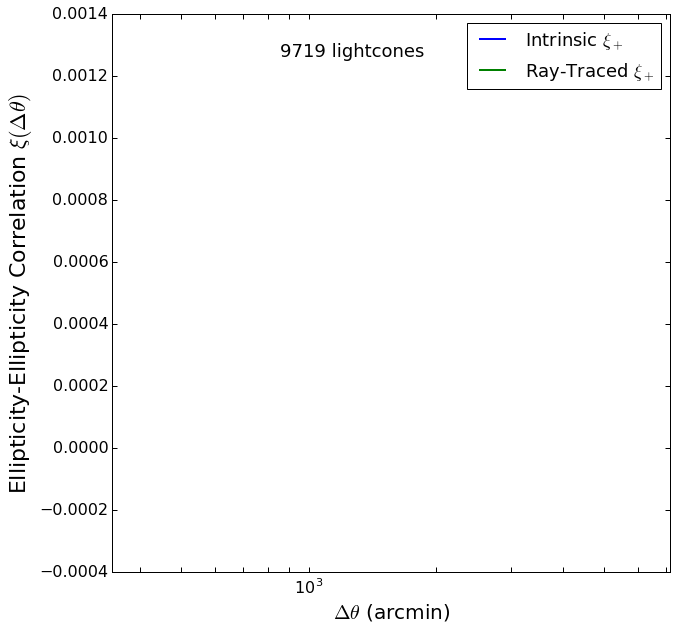

In [14]:
pangloss.plotting.plot_corr(gg_none,corr_type='gg', corr_comp='plus', lensed='none', galaxy_count=B.galaxy_count,color='blue')
pangloss.plotting.plot_corr(gg_map,corr_type='gg', corr_comp='plus', lensed='map', color='green')
pangloss.plotting.plot_corr(gg_halo,corr_type='gg', corr_comp='plus', lensed='halo', color='purple')

Plotting the galaxy-mass correlation function is an almost identical process; simply replace `corr_type` with `ng` and `corr_comp` to the desired `real` or `imag` component.

In [15]:
ng_none = B.calculate_corr(corr_type='ng', foreground=F,lensed='none')
ng_map = B.calculate_corr(corr_type='ng', lensed='map')
ng_halo = B.calculate_corr(corr_type='ng', lensed='halo')

pangloss.plotting.plot_corr(ng_none,corr_type='ng', corr_comp='real', lensed='none', galaxy_count=B.galaxy_count,color='blue')
pangloss.plotting.plot_corr(ng_map,corr_type='ng', corr_comp='real', lensed='map', color='green')
pangloss.plotting.plot_corr(ng_halo,corr_type='ng', corr_comp='real', lensed='halo', color='purple')

IOError: [Errno 2] No such file or directory: '/Users/pjm/work/stronglensing/LSST/DESC/Pangloss/pangloss/example/example.config'

Clearly there are issues with the predicted shear power on all scales in the ellipticity-ellipticity correlation function and on some scales with the galaxy-mass correlation function. For a full discussion of the predictions and shortcomings of the `Pangloss` framework, see [this paper](https://github.com/drphilmarshall/Pangloss/blob/wl/doc/FinalPaper_SEverett.pdf).